# <center>  AI / ML Project - BMI Assessment 
#### <center> ***Domain: Healthcare***

### Description:

A simple yet challenging project, to estimate the BMI based on the Gender, Height & Weight.
The complexity arises due the fact that dataset has less samples, & is highly imbalanced.
**This data frame contains the following columns:**
* Gender : Male / Female
* Height : Number (cm)
* Weight : Number (Kg)

* Index :
0 - Extremely Weak
1 - Weak
2 - Normal
3 - Overweight
4 - Obesity
5 - Extreme Obesity

# <center>1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

pd.set_option('display.max_columns', 50)

D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Importing the dataset

df = pd.read_csv('datasets/bmi.csv')
#df.drop([''],axis=1, inplace=True)

target = 'Index'
labels = ['Extremely Weak','Weak','Normal','Overweight','Obsesity','Extreme Obesity']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


The Datset consists of 4 features & 500 samples.


In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Gender      2
Index       6
Height     60
Weight    110
dtype: int64

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))

The Datset has 2 numerical & 1 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

# <center> 2. Exploratory Data Analysis (EDA)

              Target Variable Distribution             


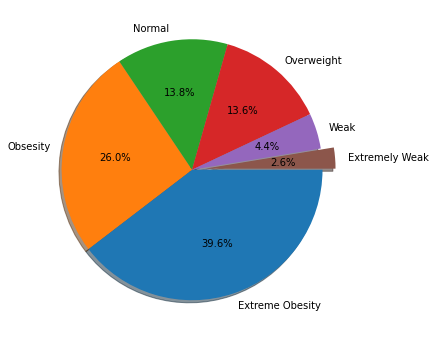

In [7]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('Target Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

**Inference:** The Target Variable seems to be slightly imbalanced! Hence we shall try to perform data augmentation.

                                 Visualising Categorical Features:                                  


D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


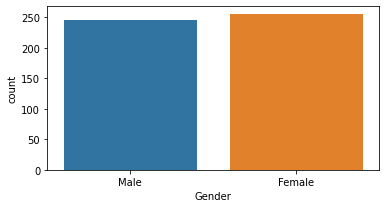

In [8]:
#Visualising the categorical features 

print('Visualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=6:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                       Features Distribution                                        


D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


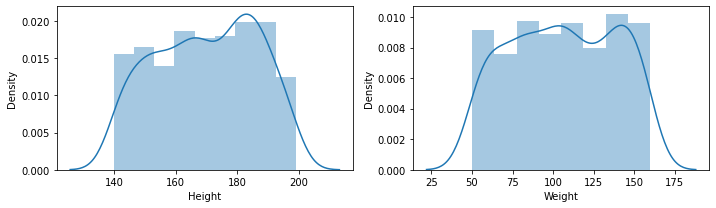

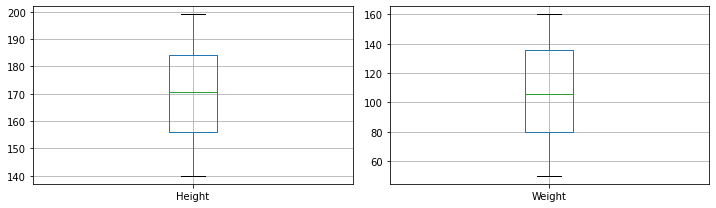

In [9]:
#Understanding the feature set

print('Features Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

D:\Projects\Machine Learning Projects\Machine-learning\ml-venv\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


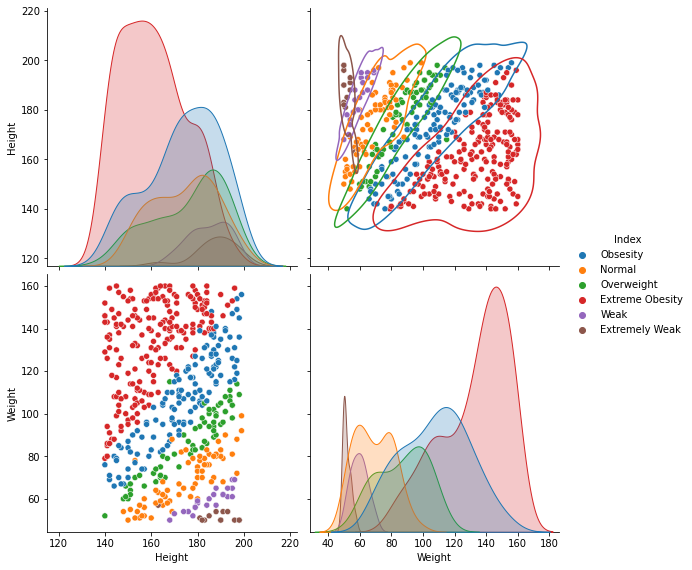

In [10]:
#Understanding the relationship between all the features

g=sns.pairplot(df1, hue=target, size=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

**Inference:** The data samples of most of the features do show some patterns. Also they seem
to have lot of overlap for the outcome classes, making it difficult to be distingusihable. 
Let is proceed to perform cleanup on the data to remove the irregularities...

---

# <center> 3. Data Preprocessing

In [11]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('The dataset doesn\'t have any duplicates')
else:
    print(f'Number of duplicates dropped ---> {r-df1.shape[0]}')

Number of duplicates dropped ---> 11


In [12]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

        Total Null Values  Percentage
Gender                  0         0.0
Height                  0         0.0
Weight                  0         0.0
Index                   0         0.0


**Inference:** There are many outliers in the dataset. Let us try to impute the missing values

In [13]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

# #Target Variable
# MAP={}
# for i,e in enumerate(df1[target].unique()):
#     MAP[e]=i
# df1[target]=df1[target].map(MAP)
# print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("One-Hot Encoding on features:")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("Dummy Encoding on features:")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
Gender


(489, 4)

In [14]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


Before removal of outliers, The dataset had 489 samples.
After removal of outliers, The dataset now has 489 samples.


In [15]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
5    195
4    128
2     69
3     64
1     20
0     13
Name: Index, dtype: int64

Class distribution after applying SMOTE Technique:
4    195
2    195
3    195
5    195
1    195
0    195
Name: Index, dtype: int64


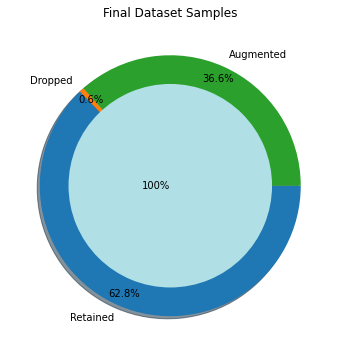

The final dataset after cleanup has 1170 samples & 4 columns.


In [16]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('The final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

---

# <center> 4. Data Manipulation

In [17]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (1170, 3) (1170,) 
Training set  --->  (936, 3) (936,) 
Testing set   --->  (234, 3)  (234,)


In [18]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('Standardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','Standardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                 Standardardization on Training set                                 


,Gender,Height,Weight
count,9.360000e+02,9.360000e+02,9.360000e+02
mean,1.518254e-17,-4.991259e-16,-1.594166e-16
std,1.000535e+00,1.000535e+00,1.000535e+00
min,-7.327659e-01,-2.346937e+00,-1.079156e+00
25%,-7.327659e-01,-7.255403e-01,-8.635089e-01
50%,-7.327659e-01,2.472976e-01,-2.781818e-01
75%,1.364692e+00,7.661445e-01,7.076323e-01
max,1.364692e+00,1.479559e+00,2.309580e+00



                                  Standardardization on Testing set                                  


,Gender,Height,Weight
count,234.000000,234.000000,234.000000
mean,0.047058,0.043307,-0.071092
std,1.015841,1.012288,0.969425
min,-0.732766,-2.346937,-1.079156
25%,-0.732766,-0.595829,-0.925122
50%,-0.732766,0.312153,-0.416812
75%,1.364692,0.879642,0.584406
max,1.364692,1.414703,2.124740


---

# <center> 5. Feature Selection/Extraction

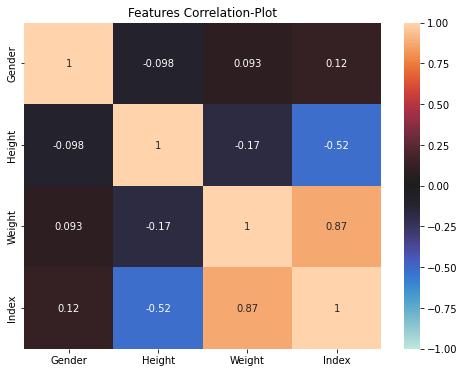

In [19]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[8,6])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #, 
plt.show()

**Inference:** \
Correlation plt between the variables convey lot of information about the realationship betweem them. There seems to be strong multicollinearity in the dataset.

Let us check with different techniques if we can improve the model's performance by performing Feature Selection/Extraction steps to take care of these multi-collinearity...

**Strategy:** \
We can fix these multicollinearity with two techniques:
1. Manual Method - Variance Inflation Factor (VIF)
2. Automatic Method - Recursive Feature Elimination (RFE)
3. Decomposition Method - Principle Component Analysis (PCA)

## 5a. Manual Method - VIF

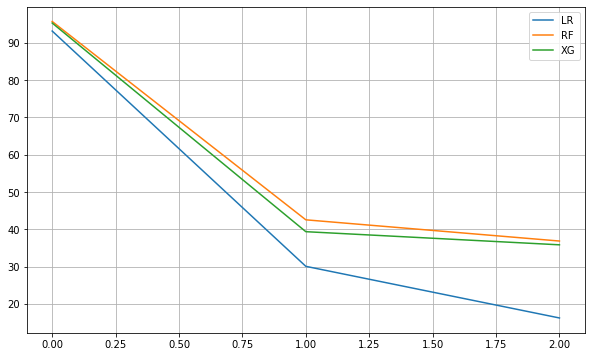

In [64]:
# Calculate the VIFs to remove multicollinearity

DROP=[]; scores1=[]; scores2=[]; scores3=[]
#scores.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std)))
scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        
for i in range(len(X.columns.values)-1):
    vif = pd.DataFrame()
    Xs = X.drop(DROP,axis=1)
    #print(DROP)
    vif['Features'] = Xs.columns
    vif['VIF'] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    DROP.append(vif.Features[0])
    if vif.VIF[0]>1:
        scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
    #print(scores)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.7,0.85])
plt.legend()
plt.grid()
plt.show()

## 5b. Automatic Method - RFE

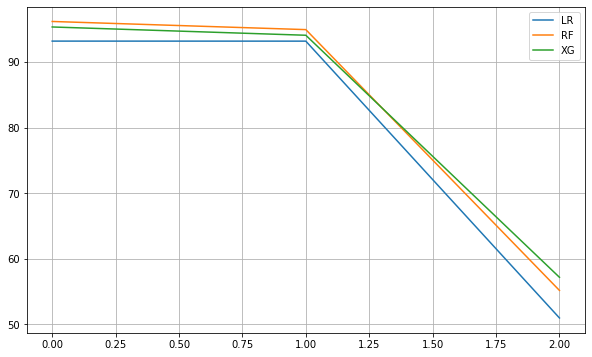

In [63]:
# Applying Recurrsive Feature Elimination

# Running RFE with the output number of the variable equal to 10
LR = LogisticRegression()#.fit(Train_X_std, Train_Y)
scores1=[]; scores2=[]; scores3=[]
# scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std, Train_Y, eval_metric='logloss').predict(Test_X_std),average='weighted')*100)

for i in range(len(X.columns.values)):
    rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-i)   
    rfe = rfe.fit(Train_X_std, Train_Y)
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.80,0.84])
plt.legend()
plt.grid()
plt.show()

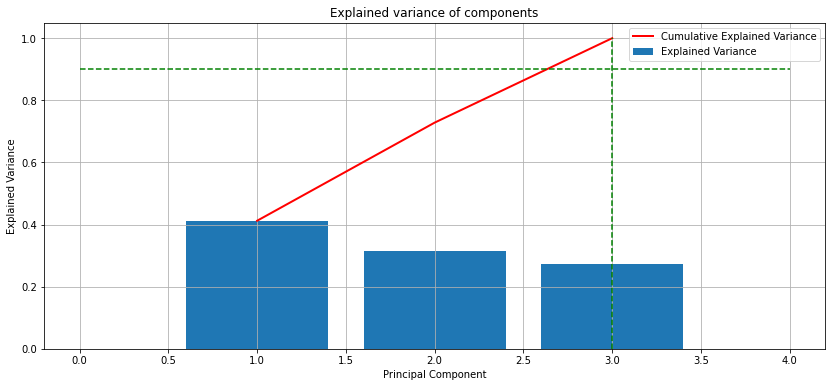

In [54]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([3,3],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

**Inference:** We shall avoid performing dimensionality reduction for the current problem.

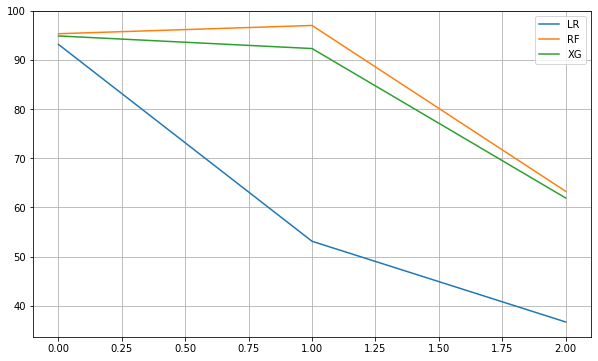

In [50]:
#Applying PCA Transformations

# scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
# scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std, Train_Y, eval_metric='logloss').predict(Test_X_std),average='weighted')*100)

scores1=[]; scores2=[]; scores3=[]
for i in range(len(X.columns.values)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    #print('The shape of final transformed training feature set:')
    #print(Train_X_std_pca.shape)
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

    Test_X_std_pca = pca.transform(Test_X_std)
    #print('\nThe shape of final transformed testing feature set:')
    #print(Test_X_std_pca.shape)
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std_pca, Train_Y, eval_metric='logloss').predict(Test_X_std_pca),average='weighted')*100)

    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
#plt.ylim([0.80,0.84])
plt.legend()
plt.grid()
plt.show()

**Inference:** In VIF, RFE & PCA Techniques, we did notice any better scores upon dropping some multicollinear features. But in order to avoid the curse of dimensionality, we can capture top 90% of the data Variance explained by top n PCA components.

---

# <center> 6. Predictive Modeling

In [30]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0
Gradient Boosting (GB),0.0,0.0,0.0,0.0,0.0
Extreme Gradient Boosting (XGB),0.0,0.0,0.0,0.0,0.0


In [48]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob)
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 97.39999999999999%
F1 Score = 97.39999999999999%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 0 48  0  0  0  0]
 [ 0  0 38  2  0  0]
 [ 0  0  2 32  1  0]
 [ 0  0  0  1 39  0]
 [ 0  0  0  0  0 33]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        48
           2       0.95      0.95      0.95        40
           3       0.91      0.91      0.91        35
           4       0.97      0.97      0.97        40
           5       1.00      1.00      1.00        33

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234



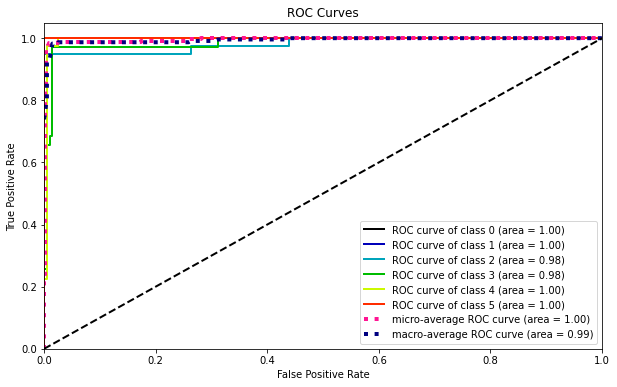


Interpreting the Output of Logistic Regression:

intercept  -19.350111441016125
classes [0 1 2 3 4 5]


,coeff
Gender,-0.308878
Height,9.661284
Weight,-33.364144


In [49]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg','liblinear']# 'lbfgs', 
space['penalty'] = ['l2'] #'none', 'l1', 'l2', 'elasticnet'
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

---

## 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 92.7%
F1 Score = 92.7%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 1 46  1  0  0  0]
 [ 4  0 35  1  0  0]
 [ 0  0  2 30  3  0]
 [ 0  0  0  3 35  2]
 [ 0  0  0  0  0 33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        38
           1       1.00      0.96      0.98        48
           2       0.92      0.88      0.90        40
           3       0.88      0.86      0.87        35
           4       0.92      0.88      0.90        40
           5       0.94      1.00      0.97        33

    accuracy                           0.93       234
   macro avg       0.93      0.93      0.93       234
weighted avg       0.93      0.93      0.93       234



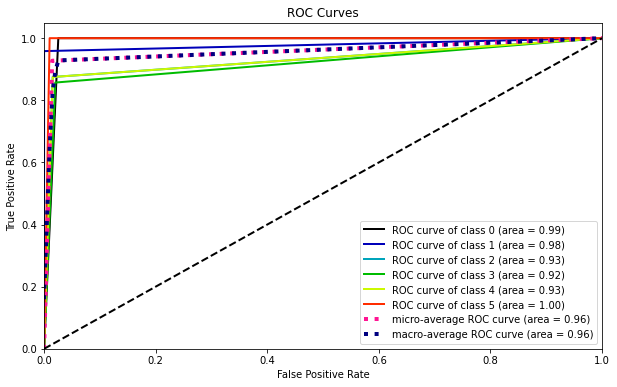


Interpreting the output of Decision Tree:



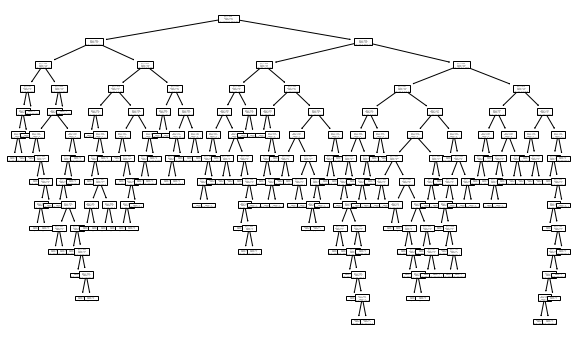

In [51]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, len(features)-1),
              "min_samples_leaf": randint(1, len(features)-1),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()

---

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 96.2%
F1 Score = 96.2%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 1 47  0  0  0  0]
 [ 2  0 37  1  0  0]
 [ 0  0  0 32  3  0]
 [ 0  0  0  1 38  1]
 [ 0  0  0  0  0 33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        38
           1       1.00      0.98      0.99        48
           2       1.00      0.93      0.96        40
           3       0.94      0.91      0.93        35
           4       0.93      0.95      0.94        40
           5       0.97      1.00      0.99        33

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



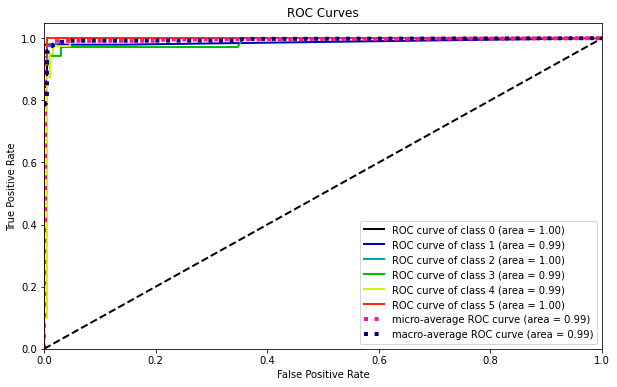


Interpreting the output of Random Forest:



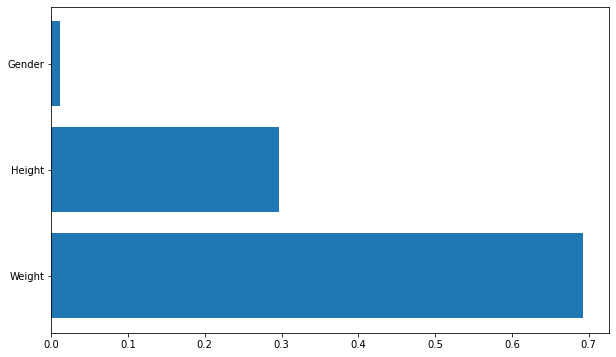

In [52]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

---

## 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 50.4%
F1 Score = 45.6%

 Confusiton Matrix:
 [[30  8  0  0  0  0]
 [20 19  9  0  0  0]
 [ 9  9 17  0  3  2]
 [ 1  0 10  0 22  2]
 [ 0  0  9  0 22  9]
 [ 0  0  0  0  3 30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.79      0.61        38
           1       0.53      0.40      0.45        48
           2       0.38      0.42      0.40        40
           3       0.00      0.00      0.00        35
           4       0.44      0.55      0.49        40
           5       0.70      0.91      0.79        33

    accuracy                           0.50       234
   macro avg       0.42      0.51      0.46       234
weighted avg       0.43      0.50      0.46       234



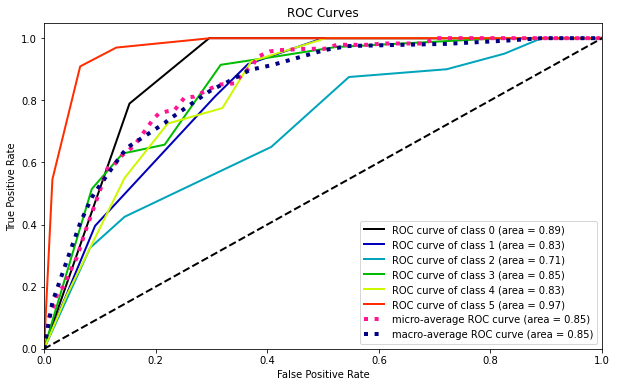

In [55]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

---

## 5. Support Vector Machine Classfier:

<<<----------------------------------- Evaluating Support Vector Machine (SVM) ----------------------------------->>>

Accuracy = 98.3%
F1 Score = 98.3%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 0 48  0  0  0  0]
 [ 0  0 39  0  1  0]
 [ 0  0  0 33  2  0]
 [ 0  0  0  1 39  0]
 [ 0  0  0  0  0 33]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        48
           2       1.00      0.97      0.99        40
           3       0.97      0.94      0.96        35
           4       0.93      0.97      0.95        40
           5       1.00      1.00      1.00        33

    accuracy                           0.98       234
   macro avg       0.98      0.98      0.98       234
weighted avg       0.98      0.98      0.98       234



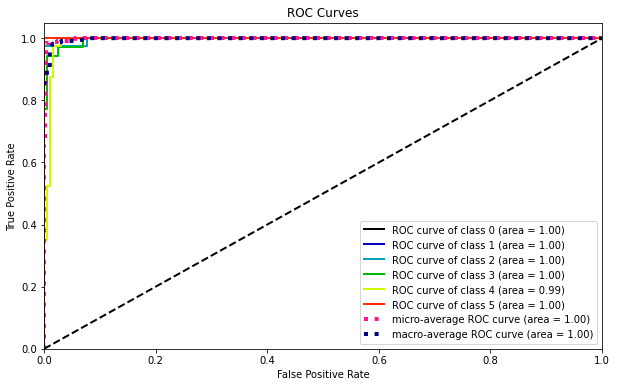

In [56]:
# Building Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,4)

---

## 6. K-Nearest Neighbours Classfier:

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 96.2%
F1 Score = 96.2%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 2 46  0  0  0  0]
 [ 1  0 39  0  0  0]
 [ 0  0  0 33  2  0]
 [ 0  0  0  1 38  1]
 [ 0  0  0  0  2 31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        38
           1       1.00      0.96      0.98        48
           2       1.00      0.97      0.99        40
           3       0.97      0.94      0.96        35
           4       0.90      0.95      0.93        40
           5       0.97      0.94      0.95        33

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



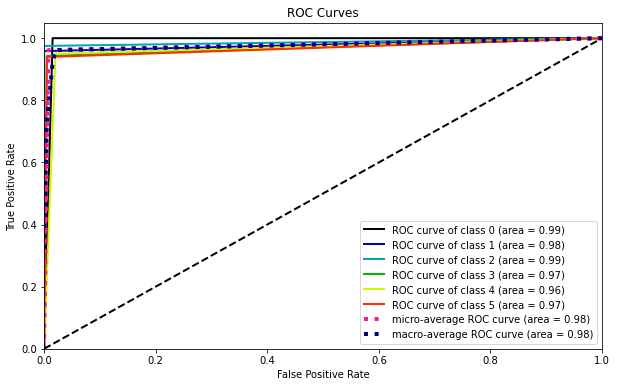

In [57]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)

---

## 7. Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 93.2%
F1 Score = 93.2%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 3 45  0  0  0  0]
 [ 3  0 35  2  0  0]
 [ 0  0  0 33  2  0]
 [ 0  0  0  2 36  2]
 [ 0  0  0  0  2 31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        38
           1       1.00      0.94      0.97        48
           2       1.00      0.88      0.93        40
           3       0.89      0.94      0.92        35
           4       0.90      0.90      0.90        40
           5       0.94      0.94      0.94        33

    accuracy                           0.93       234
   macro avg       0.93      0.93      0.93       234
weighted avg       0.94      0.93      0.93       234



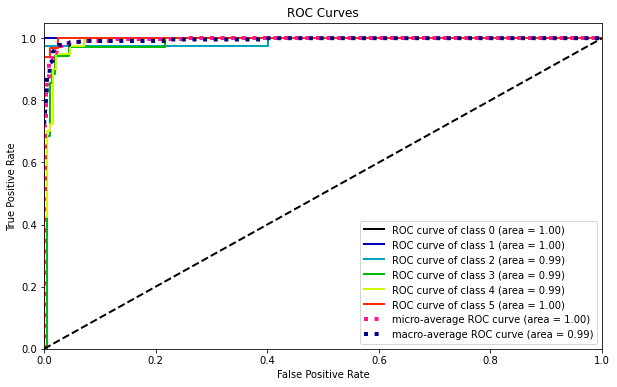

In [58]:
# Building Gradient Boosting Classifier

GB_model = GradientBoostingClassifier().fit(Train_X_std, Train_Y)
param_dist = {
    "n_estimators":[5,20,100,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, param_dist, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=5, random_state=1)

GB = GB_model.fit(Train_X_std, Train_Y)#.best_estimator_
pred = GB.predict(Test_X_std)
pred_prob = GB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,6)

---

## 8. Extreme Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Extreme Gradient Boosting (XGB) ----------------------------------->>>

Accuracy = 95.3%
F1 Score = 95.3%

 Confusiton Matrix:
 [[38  0  0  0  0  0]
 [ 3 45  0  0  0  0]
 [ 1  0 37  2  0  0]
 [ 0  0  0 33  2  0]
 [ 0  0  0  1 38  1]
 [ 0  0  0  0  1 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        38
           1       1.00      0.94      0.97        48
           2       1.00      0.93      0.96        40
           3       0.92      0.94      0.93        35
           4       0.93      0.95      0.94        40
           5       0.97      0.97      0.97        33

    accuracy                           0.95       234
   macro avg       0.95      0.95      0.95       234
weighted avg       0.96      0.95      0.95       234



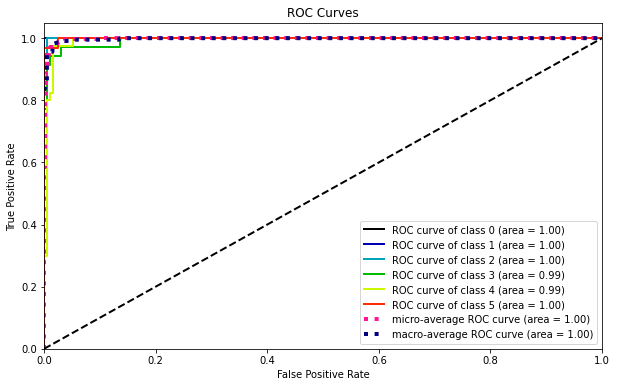

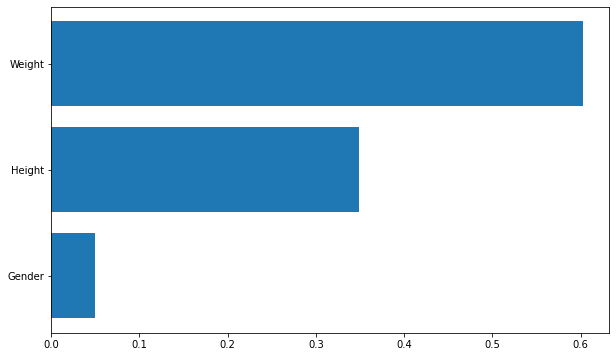

In [59]:
# Building Extreme Gradient Boosting Classifier

XGB_model = XGBClassifier()#.fit(Train_X_std, Train_Y, eval_metric='logloss')

param_dist = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#RCV = RandomizedSearchCV(XGB_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

XGB = XGB_model.fit(Train_X_std, Train_Y, eval_metric='logloss')#.best_estimator_
pred = XGB.predict(Test_X_std)
pred_prob = XGB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,7)

xgbf=pd.DataFrame(XGB.feature_importances_, index=Train_X_std.columns).sort_values(by=0)
plt.barh(xgbf.index,xgbf.values[:,0])
plt.show()

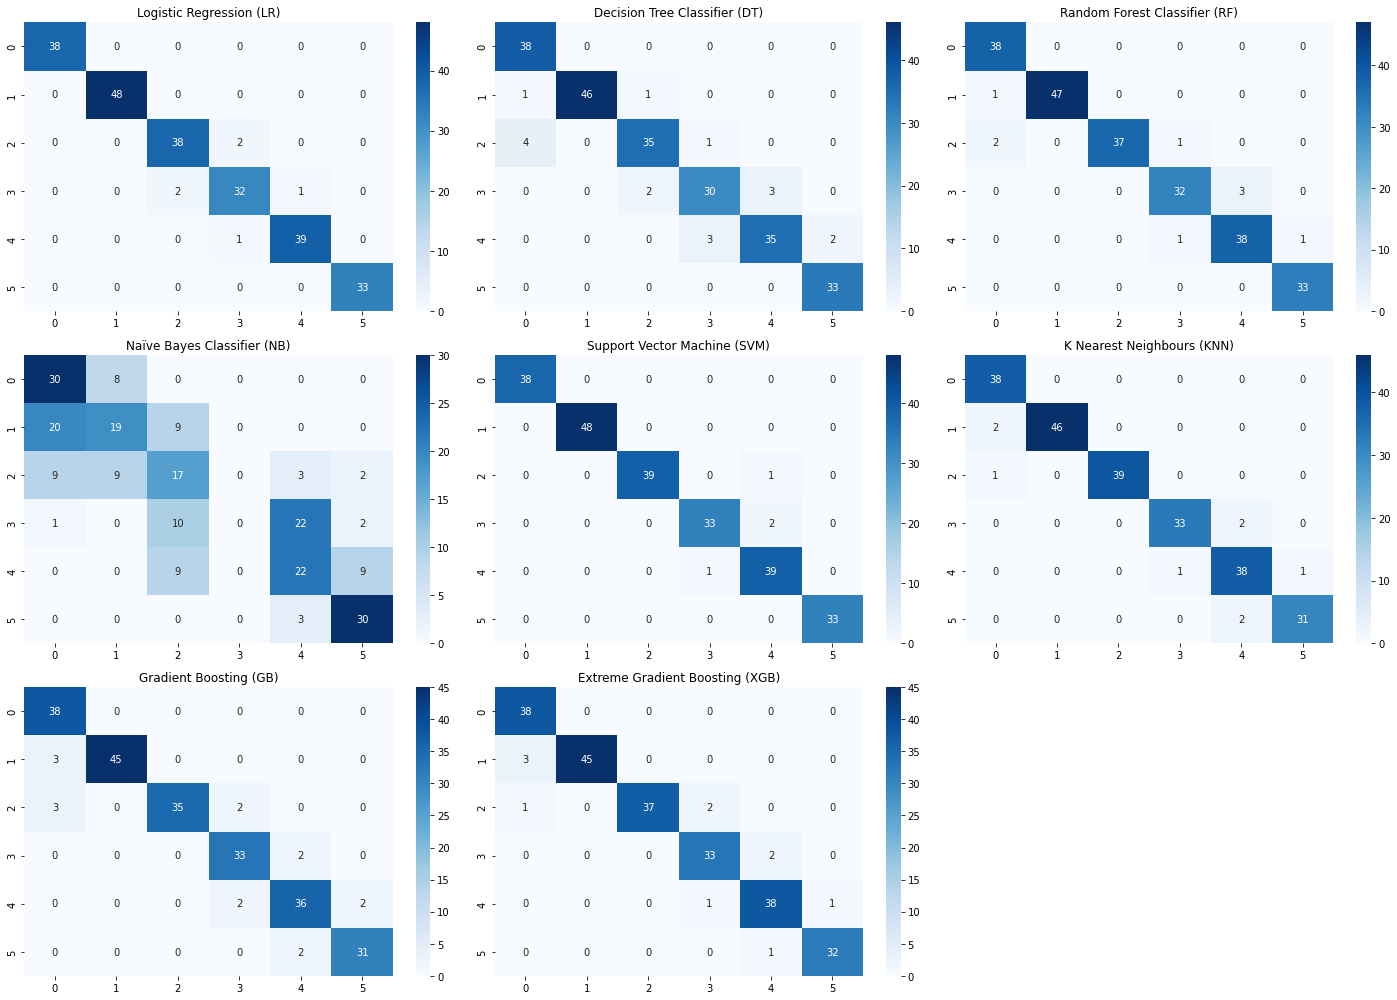

In [60]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB,SVM,KNN,GB,XGB])

                                    ML Algorithms Comparison                                    


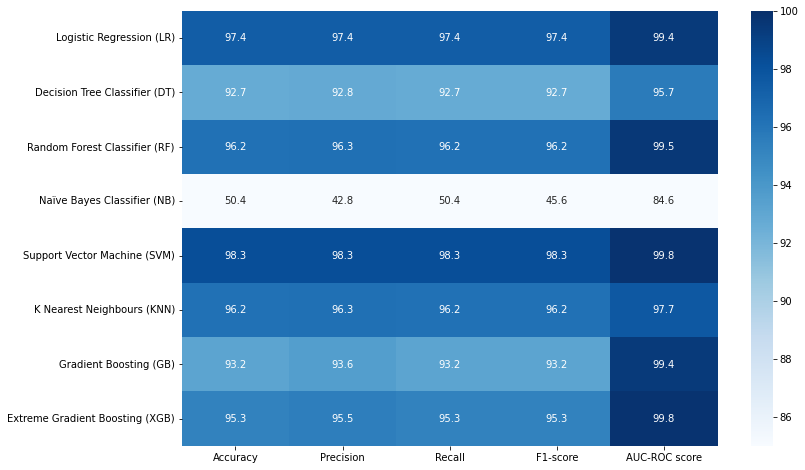

In [61]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=85, vmax=100, cmap='Blues', fmt='.1f')
plt.show()

**Insights:** For the current problem statement, it is more important to focus on the F1-score. We can note from the above heatmap that the Support Vector Machine Model Performed the best on the current dataset.

---

In [62]:
#<<<---------------------------------------------THE END----------------------------------------------------------------->>>